**<center><font size="4">IS843 - Big Data Analytics in Business</font></center>**

*<center>Team 2: Mingqian Xie, Allen Chacko, Brendan Gangl, Ritwick Roy</center>*<br>

**Dataset:** Cardiovascular Disease dataset (Kaggle - https://www.kaggle.com/sulianova/cardiovascular-disease-dataset) \
The dataset consists of 70 000 records of patients data, 11 features + target

**<font size="3">Project Overview</font>**
1. [Importing CSV file](#Importing_CSV_file)<br>
2. [Exploratory Data Analysis](#Exploratory_Data_Analysis)<br>
    2.1. [Summary Statistics](#Summary_Statistics)<br>
    2.2. [Feature Analysis](#Feature_Analysis)<br>
    2.3. [Feature Engineering](#Feature_Engineering)<br>
3. [Data Preparation](#Data_Preparation)<br>
    3.1. [Dropping columns](#Dropping_columns)<br>
    3.2. [One-hot encoding](#One_hot_encode)<br>
    3.3. [Assembling features](#Assembling_features)<br>   
4. [Machine Learning](#Machine_Learning)<br>
    4.1. [Building Models](#Building_Models)<br>
    4.2. [Analysing Feature Importance](#Analysing_Feature_Importance)<br>
    4.3. [Feature Engineering](#Feature)<br>
5. [Results](#Results)<br>
6. [Appendix](#Appendix)<br>
    6.1. [Chi-Square Test](#Chi_Square_test)<br>
    6.2. [ROC Curve](#ROC_Curve)<br>
    6.3. [PCA](#PCA)<br>

<br>**<font size="3">The Description Of Columns</font>**<br><br>
age | patient's age | int (days)<br>
height | patient's height | int (cm)<br>
weight | patient's weight | float (kg) <br>
gender | patient's gender | 1: women, 2: men<br>
ap_hi | systolic blood pressure | int <br>
ap_lo | diastolic blood pressure | int <br>
cholesterol | cholesterol levels | 1: normal, 2: above normal, 3: well above normal <br>
gluc | glucose levels | 1: normal, 2: above normal, 3: well above normal <br>
smoke | whether patient smokes | binary | 0: no, 1: yes <br>
alco | patient's alcohol intake | binary | 0: no, 1: yes <br>
active | is patient physically active | binary | 0: no, 1: yes <br>
cardio | presence or absence of cardiovascular disease | binary | 0: no, 1: yes | **Target Variable**<br>

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructField,StructType,StringType,IntegerType,LongType,FloatType
from pyspark.sql.functions import col,column,expr,lit,corr,udf,count,countDistinct,min,max,avg,mean,stddev_pop,stddev_samp,desc,asc,covar_pop
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import sys
#import databricks.koalas as ks
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

<a id='Importing_CSV_file'></a>
## 1. Importing CSV file

In [3]:
data = "gs://is843-team2-project/team2-project/"

In [99]:
!gsutil ls {data}

gs://is843-team2-project/team2-project/
gs://is843-team2-project/team2-project/cardio_train_cleaned_new_age.csv


In [2]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("nullValue", "NA")\
  .option("inferSchema", "true")\
  .load("gs://is843-team2-project/team2-project/cardio_train_cleaned_new_age.csv")

In [3]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_year: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [102]:
df.cache()

DataFrame[id: int, age: int, age_year: double, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int]

<a id='Exploratory_Data_Analysis'></a>
## 2. Exploratory Data Analysis

In [3]:
df.show(3)

+---+-----+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|age_year|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|    50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|    55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|    51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
+---+-----+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 3 rows



<a id='Summary_Statistics'></a>
### 2.1. Summary Statistics

In [104]:
df.describe().show(truncate=False,vertical=True)

-RECORD 0---------------------------
 summary     | count                
 id          | 70000                
 age         | 70000                
 age_year    | 70000                
 gender      | 70000                
 height      | 70000                
 weight      | 70000                
 ap_hi       | 70000                
 ap_lo       | 70000                
 cholesterol | 70000                
 gluc        | 70000                
 smoke       | 70000                
 alco        | 70000                
 active      | 70000                
 cardio      | 70000                
-RECORD 1---------------------------
 summary     | mean                 
 id          | 49972.4199           
 age         | 19468.865814285713   
 age_year    | 53.33948571428545    
 gender      | 1.3495714285714286   
 height      | 164.35922857142856   
 weight      | 74.20569             
 ap_hi       | 128.8172857142857    
 ap_lo       | 96.63041428571428    
 cholesterol | 1.3668714285714285   
 

#### 2.1.1 Filtering data for outliers and datapoints outside of value ranges

The Summary description reveales that some datapoints had values of ap_lo and ap_hi that were outside acceptable range.
The acceptable range for diastolic blood pressure (ap_lo) is between 40 and 180
The acceptable range for systolic blood pressure (ap_hi) is between 70 and 240
It is likely that these data points are the results of either faulty measurement or faulty entry of data.
We eliminate these faulty data points.

In [3]:
df = df.where((df['ap_hi'] < 240) & (df['ap_lo'] < 180) & (df['ap_hi'] > 70) & (df['ap_lo'] > 40))

In [106]:
print("The Cardiovascular Disease DataFrame has {} records. They include the following:".format(df.count()))
print("   Male records: {}".format(df.where(col('gender') == 2).count()))
print("   Female records: {}".format(df.where(col('gender') == 1).count()))
print("   Records with high cholesterol: {}".format(df.where(col('cholesterol') == 3).count()))
print("   Number of smokers: {}".format(df.where(col('smoke') == 1).count()))
print("   Number of alcohol drinkers: {}".format(df.where(col('alco') == 1).count()))
print("   Number of physically active individuals: {}".format(df.where(col('active') == 1).count()))
print("Number of individuals with cardiovascular disease: {}".format(df.where(col('cardio') == 1).count()))
print('Average height of males {} cms'.format(df.where(col('gender')==2).agg(F.avg(col('height'))).collect()[0][0]))
print('Average height of females {} cms'.format(df.where(col('gender')==1).agg(F.avg(col('height'))).collect()[0][0]))
print('Average weight of males {} kgs'.format(df.where(col('gender')==2).agg(F.avg(col('weight'))).collect()[0][0]))
print('Average weight of females {} kgs'.format(df.where(col('gender')==1).agg(F.avg(col('weight'))).collect()[0][0]))
print('Average age of males {} years'.format(df.where(col('gender')==2).agg(F.avg(col('age_year'))).collect()[0][0]))
print('Average age of females {} years'.format(df.where(col('gender')==1).agg(F.avg(col('age_year'))).collect()[0][0]))
print('Average ap_lo of males {}'.format(df.where(col('gender')==2).agg(F.avg(col('ap_lo'))).collect()[0][0]))
print('Average ap_hi of males {}'.format(df.where(col('gender')==2).agg(F.avg(col('ap_hi'))).collect()[0][0]))
print('Average ap_lo of females {}'.format(df.where(col('gender')==1).agg(F.avg(col('ap_lo'))).collect()[0][0]))
print('Average ap_hi of females {}'.format(df.where(col('gender')==1).agg(F.avg(col('ap_hi'))).collect()[0][0]))
print('Average age with normal choleterol {} years'.format(df.where(col('cholesterol')==1).agg(F.avg(col('age_year'))).collect()[0][0]))
print('Average age with above normal choleterol {} years'.format(df.where(col('cholesterol')==2).agg(F.avg(col('age_year'))).collect()[0][0]))
print('Average age with well above choleterol {} years'.format(df.where(col('cholesterol')==2).agg(F.avg(col('age_year'))).collect()[0][0]))

The Cardiovascular Disease DataFrame has 68731 records. They include the following:
   Male records: 23968
   Female records: 44763
   Records with high cholesterol: 7881
   Number of smokers: 6049
   Number of alcohol drinkers: 3682
   Number of physically active individuals: 55222
Number of individuals with cardiovascular disease: 34015
Average height of males 169.94826435246995 cms
Average height of females 161.37224940240824 cms
Average weight of males 77.17704856475301 kgs
Average weight of females 72.4875678573822 kgs
Average age of males 53.112787883844845 years
Average age of females 53.44230502870654 years
Average ap_lo of males 82.24841455273699
Average ap_hi of males 128.0052152870494
Average ap_lo of females 80.90449701762617
Average ap_hi of females 125.86882023099434
Average age with normal choleterol 52.818455718304364 years
Average age with above normal choleterol 53.69893605588394 years
Average age with well above choleterol 53.69893605588394 years


In [107]:
df.groupBy(col('cardio')).agg(F.count('id').alias('count')).withColumn('Rate %',F.round(100*col('count')/df.count(),2)).show()

+------+-----+------+
|cardio|count|Rate %|
+------+-----+------+
|     1|34015| 49.49|
|     0|34716| 50.51|
+------+-----+------+



This is a balanced dataset. The rate of cardiovascular and non-cardiovascular cases is about the same.

#### 2.1.2. Checking for Null values and duplicate rows

In [108]:
listOfColumns = df.schema.names
null_count = [df.where(col(x).isNull()).count() for x in listOfColumns]

if np.sum(np.array(null_count)) == 0:
    print('Data has NO Null Values')
    
if df.count() == df.dropDuplicates(listOfColumns).count():
    print('Data has NO duplicates')
    

Data has NO Null Values
Data has NO duplicates


<a id='Feature_Analysis'></a>
### 2.2. Feature Analysis

In [109]:
df_eda = df.withColumn("age", round(col('age') / 365))\
  .withColumn("gender", regexp_replace(col("gender"), "2", "Male"))\
  .withColumn("gender", regexp_replace(col("gender"), "1", "Female"))\
  .withColumn("cholesterol", regexp_replace(col("cholesterol"), "1", "normal"))\
  .withColumn("cholesterol", regexp_replace(col("cholesterol"), "2", "above normal"))\
  .withColumn("cholesterol", regexp_replace(col("cholesterol"), "3", "well above normal"))\
  .withColumn("gluc", regexp_replace(col("gluc"), "1", "normal"))\
  .withColumn("gluc", regexp_replace(col("gluc"), "2", "above normal"))\
  .withColumn("gluc", regexp_replace(col("gluc"), "3", "well above normal"))\
  .withColumn("smoke", regexp_replace(col("smoke"), "0", "no"))\
  .withColumn("smoke", regexp_replace(col("smoke"), "1", "yes"))\
  .withColumn("alco", regexp_replace(col("alco"), "0", "no"))\
  .withColumn("alco", regexp_replace(col("alco"), "1", "yes"))\
  .withColumn("active", regexp_replace(col("active"), "0", "no"))\
  .withColumn("active", regexp_replace(col("active"), "1", "yes"))\
  .withColumn("cardio", regexp_replace(col("cardio"), "0", "no"))\
  .withColumn("cardio", regexp_replace(col("cardio"), "1", "yes"))

In [110]:
df_eda.cache()

DataFrame[id: int, age: double, age_year: double, gender: string, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: string, gluc: string, smoke: string, alco: string, active: string, cardio: string]

***Functions for plotting variables: Pct of Patients with Cardiovascular Disease***

In [111]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(py_df_eda[py_df_eda['cardio'] == 'no'][feature].dropna(), color= 'navy')
    ax1 = sns.kdeplot(py_df_eda[py_df_eda['cardio'] == 'yes'][feature].dropna(), color= 'green')
    plt.legend(['No Disease','Disease'], loc ='upper left')

In [112]:
def plotstack(df):
    #sns.set()
    height,width = [], []
    splot = df.set_index(df.columns[0]).plot(kind='bar', color = ['steelblue','gainsboro'], stacked=True)
    plt.legend(loc ='upper right' )
    plt.xticks(rotation = 0)
    plt.ylabel("Number of People")
    for p in splot.patches:
        width += [p.get_width()]
        height += [p.get_height()]
    height *= 2
    for i in range(len(splot.patches)):
        x, y = splot.patches[i].get_xy() 
        splot.text(x+width[i]/2, y+height[i]/2,\
                   '{:.2f}%'.format(100*height[i]/(height[i]+height[i+len(df)])), ha='center',va='center')


In [113]:
py_df_eda = df_eda.toPandas()

***Feature Correlations***

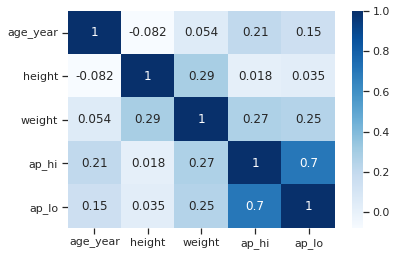

In [114]:
corr_cols = ['age_year','height','weight','ap_hi','ap_lo']
py_df_eda_numeric = py_df_eda[corr_cols]
py_df_eda_corr = py_df_eda_numeric.corr()
fig = sns.heatmap(py_df_eda_corr, annot = True, cmap='Blues')
plt.show(fig)

***Pair Plot***

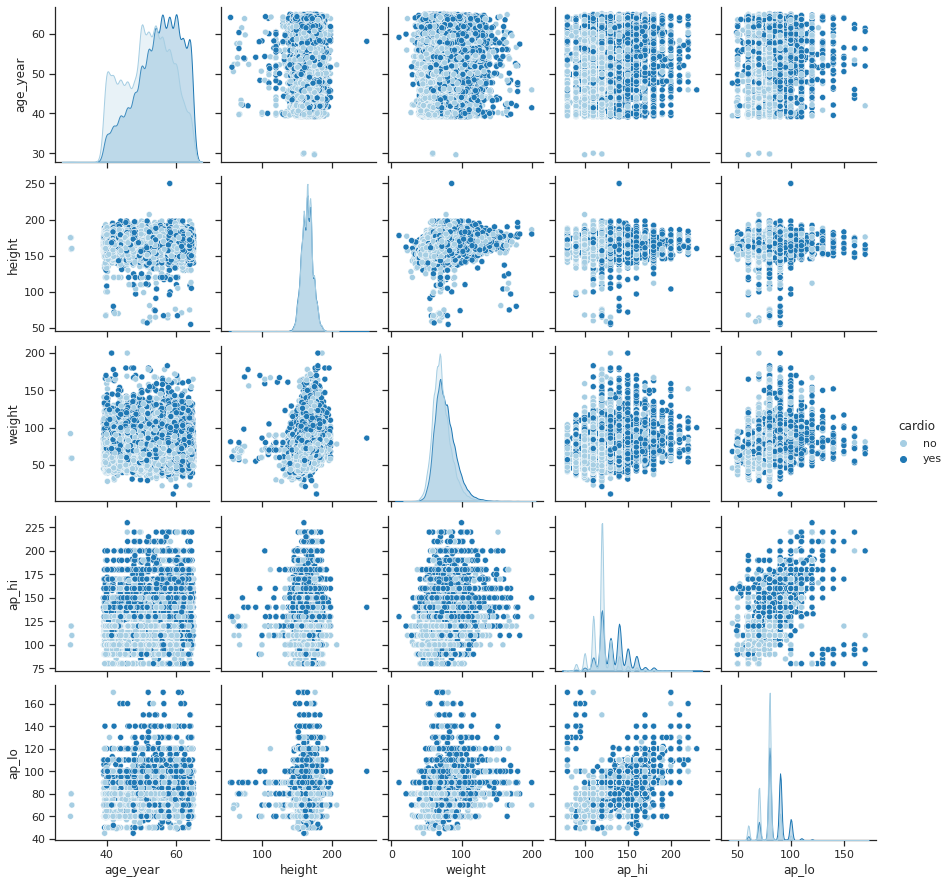

In [115]:
df_cols = ['age_year','height','weight','ap_hi','ap_lo','cardio']
py_df_eda_cols = py_df_eda[df_cols]
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(py_df_eda_cols, hue='cardio',palette = "Paired", vars=['age_year','height','weight','ap_hi','ap_lo'])
plt.show(fig)

#### 2.2.1. Gender

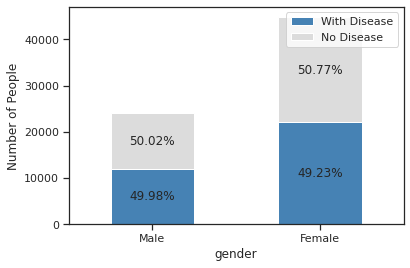

In [116]:
eda_gender = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('gender')).count().select('gender', col('count').alias('Patients with Cardiovascular Disease'))\

total_gender = df_eda.groupBy(col('gender')).count()

joined_gender = eda_gender.join(total_gender, ['gender'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_gender = joined_gender.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_gender = joined_gender.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_gender = joined_gender.drop('Pct of Patients')
joined_gender = joined_gender.drop('Total Patients')
joined_gender = joined_gender.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_gender.toPandas())

Analysis: Gender does not appear to be a strong predictor of disease. The percent of patients with cardiovascular disease does not appear to differ between males & females.

#### 2.2.2. Cholesterol

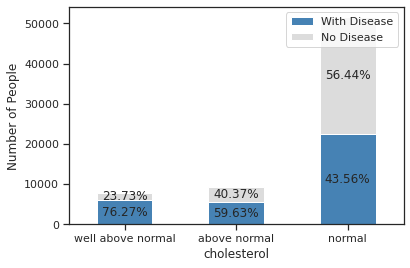

In [117]:
eda_cholesterol = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('cholesterol')).count().select('cholesterol', col('count').alias('Patients with Cardiovascular Disease'))\

total_cholesterol = df_eda.groupBy(col('cholesterol')).count()

joined_cholesterol = eda_cholesterol.join(total_cholesterol, ['cholesterol'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_cholesterol = joined_cholesterol.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_cholesterol = joined_cholesterol.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_cholesterol = joined_cholesterol.drop('Pct of Patients')
joined_cholesterol = joined_cholesterol.drop('Total Patients')
joined_cholesterol = joined_cholesterol.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_cholesterol.toPandas())

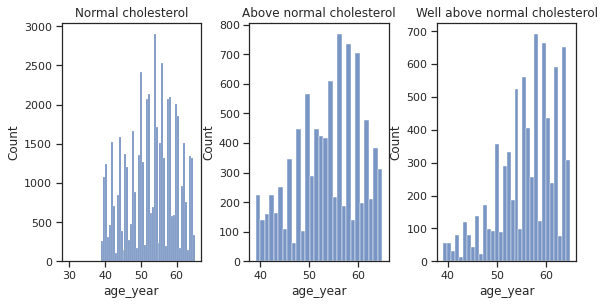

In [118]:
chol_normal = df.where(col('cholesterol')==1)
chol_above_normal = df.where(col('cholesterol')==2)
chol_well_above_normal = df.where(col('cholesterol')==3)
chol_normal_py = chol_normal.toPandas()
chol_above_normal_py = chol_above_normal.toPandas()
chol_well_above_normal_py = chol_well_above_normal.toPandas()
fig,ax=plt.subplots(1,3, figsize=(8,4))
fig.tight_layout()
sns.histplot(data=chol_normal_py,x='age_year',ax=ax[0])
sns.histplot(data=chol_above_normal_py,x='age_year',ax=ax[1])
sns.histplot(data=chol_well_above_normal_py,x='age_year',ax=ax[2])
ax[0].set_title('Normal cholesterol')
ax[1].set_title('Above normal cholesterol')
ax[2].set_title('Well above normal cholesterol')
fig.show()

Well above normal cholesterol seems to occur more frequently with increase in age

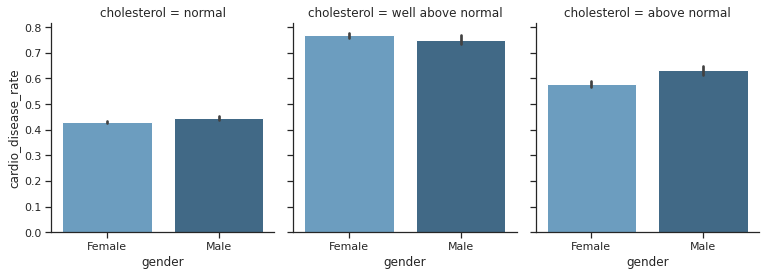

In [119]:
py_df_eda['cardio_disease_rate'] = py_df_eda['cardio'].replace("no", 0).replace("yes", 1)

g = sns.FacetGrid(py_df_eda, col="cholesterol", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "cardio_disease_rate", palette = "Blues_d", order= ['Female', 'Male'])

Analysis: The rate of cardiovascular disease does appear to increase as cholesterol levels increase. Additionally, individuals with higher than normal cholesterol tend to skew older than the average age of 53 for data. This suggests that age could also be a predictor of cardiovascular disease. Evaluating these variables by gender again does not show any distinctions between males and females.

#### 2.2.3. Glucose Levels

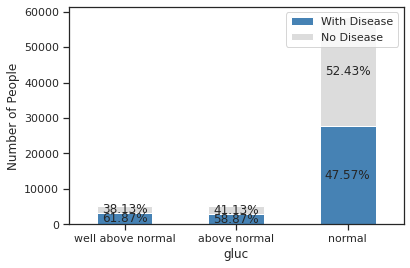

In [120]:
eda_gluc = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('gluc')).count().select('gluc', col('count').alias('Patients with Cardiovascular Disease'))\

total_gluc = df_eda.groupBy(col('gluc')).count()

joined_gluc = eda_gluc.join(total_gluc, ['gluc'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_gluc = joined_gluc.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_gluc = joined_gluc.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_gluc = joined_gluc.drop('Pct of Patients')
joined_gluc = joined_gluc.drop('Total Patients')
joined_gluc = joined_gluc.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_gluc.toPandas())

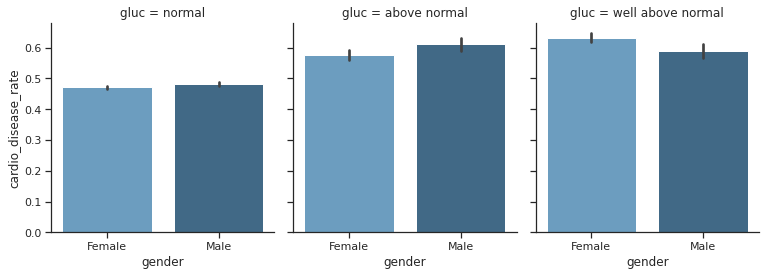

In [121]:
g = sns.FacetGrid(py_df_eda, col="gluc", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "cardio_disease_rate", palette = "Blues_d", order= ['Female', 'Male'])

Analysis: Similar to cholestrol, higher levels of glucose also seem to relate to higher rates of cardiovascular disease. Male's demonstrate slightly higher levels of cardiovascular disease when glucose levels are above normal, but females demonstrate slightly higher levels of cardiovascular disease when glocose levels are well above normal.

#### 2.2.4. smoke | whether patient smokes

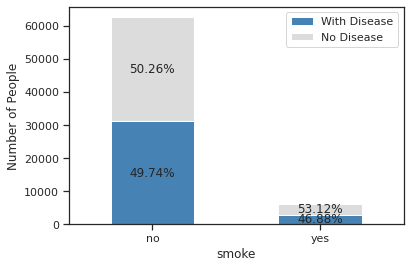

In [122]:
eda_smoke = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('smoke')).count().select('smoke', col('count').alias('Patients with Cardiovascular Disease'))\

total_smoke = df_eda.groupBy(col('smoke')).count()

joined_smoke = eda_smoke.join(total_smoke, ['smoke'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_smoke = joined_smoke.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_smoke = joined_smoke.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_smoke = joined_smoke.drop('Pct of Patients')
joined_smoke = joined_smoke.drop('Total Patients')
joined_smoke = joined_smoke.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_smoke.toPandas())

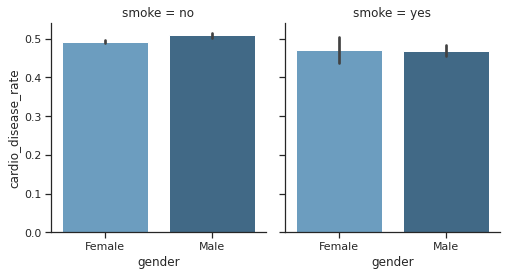

In [123]:
g = sns.FacetGrid(py_df_eda, col="smoke", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "cardio_disease_rate", palette = "Blues_d", order= ['Female', 'Male'])

Analysis: Smoking does not appear to be a strong indicator of cardiovascular disease. Individuals who smoke have a slightly lower rate of cardiovascular disease compared with those who do not smoke, and again there does not appear to much of a difference in rate of disease between genders.

#### 2.2.5. Patient's alcohol intake

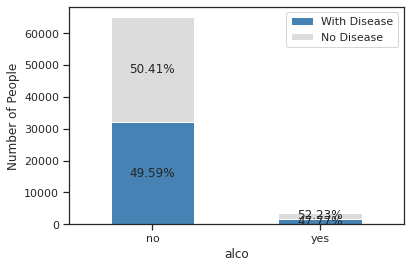

In [124]:
eda_alco = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('alco')).count().select('alco', col('count').alias('Patients with Cardiovascular Disease'))\

total_alco = df_eda.groupBy(col('alco')).count()

joined_alco = eda_alco.join(total_alco, ['alco'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_alco = joined_alco.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_alco = joined_alco.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_alco = joined_alco.drop('Pct of Patients')
joined_alco = joined_alco.drop('Total Patients')
joined_alco = joined_alco.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_alco.toPandas())

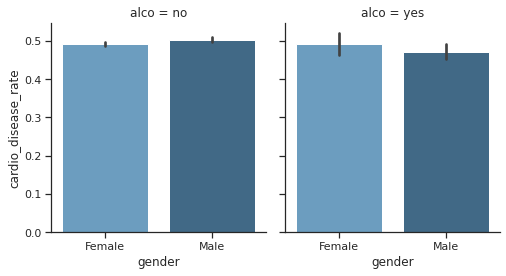

In [125]:
g = sns.FacetGrid(py_df_eda, col="alco", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "cardio_disease_rate", palette = "Blues_d", order= ['Female', 'Male'])

Analysis: Drinking alcohol also does not appear to be a strong indicator of cardiovascular disease. Individuals who drink have a slightly lower rate of cardiovascular disease compared with those who do not drink, and again there does not appear to much of a difference in rate of disease between genders.

#### 2.2.6. Patient physically active

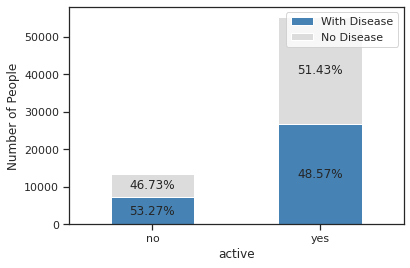

In [126]:
eda_active = df_eda.where(col('cardio') == 'yes')\
  .groupBy(col('active')).count().select('active', col('count').alias('Patients with Cardiovascular Disease'))\

total_active = df_eda.groupBy(col('active')).count()

joined_active = eda_active.join(total_active, ['active'])\
  .withColumn('Pct of Patients', round(col('Patients with Cardiovascular Disease')/col('count'),2))\
  .withColumnRenamed('count', 'Total Patients')\
  .orderBy(col('Pct of Patients').desc())

joined_active = joined_active.withColumn('With Disease', col('Patients with Cardiovascular Disease'))
joined_active = joined_active.withColumn('No Disease', col('Total Patients')-col('With Disease'))
joined_active = joined_active.drop('Pct of Patients')
joined_active = joined_active.drop('Total Patients')
joined_active = joined_active.drop('Patients with Cardiovascular Disease')
                                   
plotstack(joined_active.toPandas())

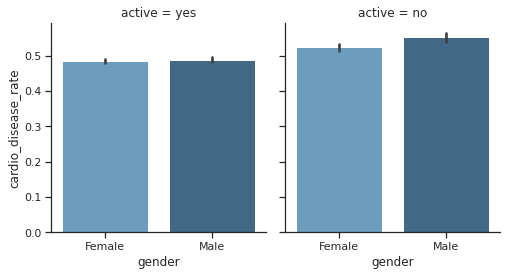

In [127]:
g = sns.FacetGrid(py_df_eda, col="active", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "cardio_disease_rate", palette = "Blues_d", order= ['Female', 'Male'])

Analysis: Being active does not appear to be a strong indicator of cardiovascular disease. Individuals who are active have a slightly lower rate of cardiovascular disease compared with those who are not active, and again there does not appear to much of a difference in rate of disease between genders.

#### 2.2.7. Patient's Age

***Kernel Density Plots:*** for continous variable we use KDE plots to see how the distribution of data points for patients with cardiovascuar disease compare to patients without cardiovascular disease. 

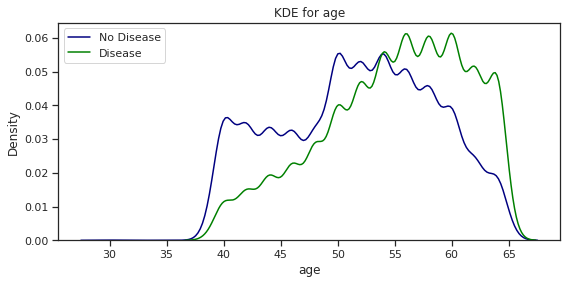

In [128]:
kdeplot('age')

Analysis: As seen with the cholesterol plots above, we do see that the distribution of data for patients with cardiovascular disease skew towards older patients compared to patients without cardiovascular disease.

#### 2.2.8. Patient's Weight

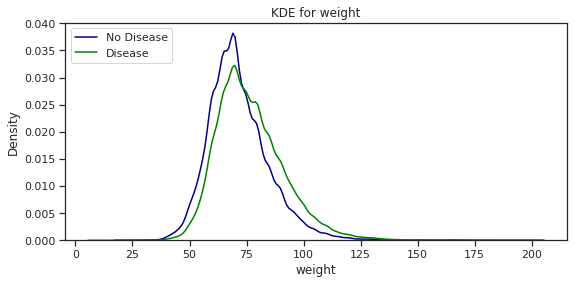

In [129]:
kdeplot('weight')

Analysis: Weight appears to be a possible indicator of cardiovascular disease as well, as we see a higher density for patients with cardiovascular disease above 75 kgs.

#### 2.2.9. Height

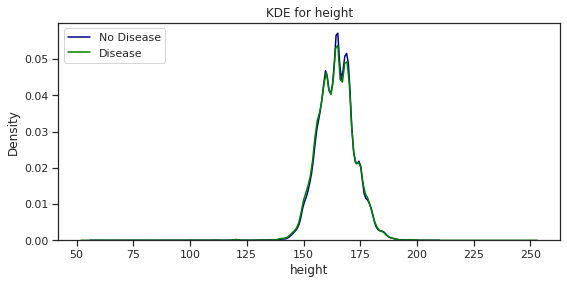

In [130]:
kdeplot('height')

Analysis: The distribution of datapoints did not differ based on height.

#### 2.2.10. ap_hi | systolic blood pressure 

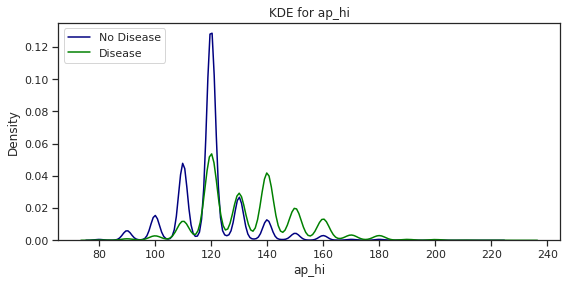

In [131]:
kdeplot('ap_hi')

#### 2.2.11. ap_lo | diastolic blood pressure

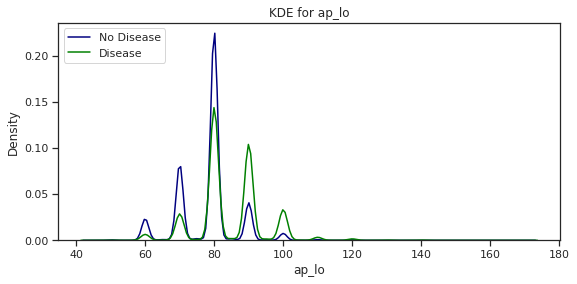

In [132]:
kdeplot('ap_lo')

Analysis: Patients with cardiovascular disease appear to have a higher density of datapoints at 130 and above for systolic blood pressure, whereas those without cardiovascular disease have a higher concentration around 120 and below. We see a similar trend for diastolic blood pressure, suggesting blood pressure could be a possible indicator for cardiovascular disease.

<a id='Feature_Engineering'></a>
### 2.3. Feature Engineering
We create new features by transforming the given variables into related variables that we calculate as possible predictors of cardiovascular disease. In this case we examine body mass index.

#### 2.3.1. BMI | Body mass index

In [133]:
py_df_eda['BMI'] = py_df_eda['weight']/(py_df_eda['height']/100)**2

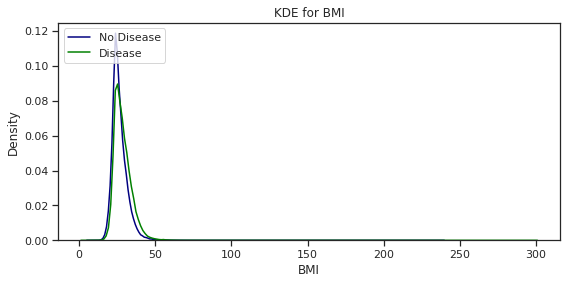

In [134]:
kdeplot('BMI')

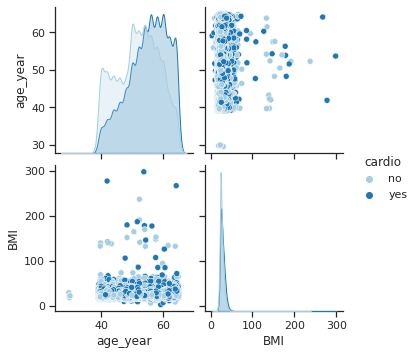

In [135]:
df_cols = ['age_year','BMI','cardio']
py_df_eda_cols = py_df_eda[df_cols]
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(py_df_eda_cols, hue='cardio',palette = "Paired", vars=['age_year','BMI'])
plt.show(fig)

***Summary of EDA***
1. Well above normal cholesterol seems to have a high influence on cardiovascular condition
2. Well above normal cholesterol seems to be more frequent in higher age group. Therefore age may be a factor in cardiovascular condition
3. Well above normal Glucose level also influences cardiovascular condition.
4. Individuals with higher blood pressure and weight have a higher chance of cardiovascular condition.
5. Smoking, drinking alcohol and inactivity doesn't seem to play that statistically significant role in cardivascular health.

<a id='Data_Preparation'></a>
## 3. Data Preparation

<a id='Dropping_columns'></a>
### 3.1. Dropping columns
We drop id and age columns since id is not a predictor and age_year contains the same information

In [4]:
dropcol = ['id','age']
df = df.drop(*dropcol)
df.show(3)

+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age_year|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|    50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|    55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|    51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 3 rows



<a id='One_hot_encode'></a>
### 3.2. One-hot encode categorical features

In [5]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active'],
                       outputCols=['gender2','cholesterol2', 'gluc2', 'smoke2', 'alco2', 'active2'])
model = encoder.fit(df)
encoded = model.transform(df)
encoded.show(5)

+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+-------------+-------------+-------------+-------------+-------------+-------------+
|age_year|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|        gluc2|       smoke2| cholesterol2|        alco2|      gender2|      active2|
+--------+------+------+------+-----+-----+-----------+----+-----+----+------+------+-------------+-------------+-------------+-------------+-------------+-------------+
|    50.4|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (2,[],[])|    (1,[],[])|
|    55.4|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|    (1,[],[])|
|    51.7|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1

The continous and the one-hot-encoded features saved as a new data-frame
* Prepare a list (featureCol) of feature columns<br>
* Prepare a list (dropcolOrig) of original feature columns to be dropped prior to saving as a new data frame: df_enc<br>
* Prepare a list (dropcolOrigenc) of original feature and encoded columns to be dropped prior to saving as a compressed data frame. This data frame will only have features and labels column: df_comp

In [6]:
featureCol = ['age_year','height','weight','ap_hi','ap_lo','gluc2','smoke2','cholesterol2','alco2','gender2','active2']
dropcolOrig = ['age','gender','cholesterol', 'gluc', 'smoke', 'alco', 'active']
dropcolOrigenc = ['age','age_year','height','weight','ap_hi','ap_lo','gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','gluc2','smoke2','cholesterol2','alco2','gender2','active2']

In [7]:
df_enc = encoded.drop(*dropcolOrig)
df_enc.show(3)

+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+-------------+
|age_year|height|weight|ap_hi|ap_lo|cardio|        gluc2|       smoke2| cholesterol2|        alco2|      gender2|      active2|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+-------------+
|    50.4|   168|  62.0|  110|   80|     0|(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (2,[],[])|    (1,[],[])|
|    55.4|   156|  85.0|  140|   90|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|    (1,[],[])|
|    51.7|   165|  64.0|  130|   70|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(1,[0],[1.0])|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+-------------+
only showing top 3 rows



<a id='Assembling_features'></a>
### 3.3. Assembling features
We assemble all features from encoded dataframe together into a compressed dataframce df_comp

In [8]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols=featureCol,outputCol="features")
df_comp = va.transform(encoded)
df_comp= df_comp.drop(*dropcolOrigenc)
df_comp.show(3)

+------+--------------------+
|cardio|            features|
+------+--------------------+
|     0|(16,[0,1,2,3,4,6,...|
|     1|(16,[0,1,2,3,4,6,...|
|     1|[51.7,165.0,64.0,...|
+------+--------------------+
only showing top 3 rows



<a id='Machine_Learning'></a>
## 4. Machine Learning

In [9]:
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

***Function for classification report***

In [10]:
def classificationReport(prediction):
    TP = prediction.filter('prediction = 1 AND label = prediction').count()
    FN = prediction.filter('prediction = 0 AND label <> prediction').count()
    FP = prediction.filter('prediction = 1 AND label <> prediction').count()
    TN = prediction.filter('prediction = 0 AND label = prediction').count()
    print()
    print('CONFUSION MATRIX:')
    print('TP:{}   FN:{}'.format(TP,FN))
    print('FP:{}   TN:{}'.format(FP,TN))
    precision = TP/(TP+FP)
    recall = TP / (TP+FN)
    f1 = (2.0*precision*recall)/(precision+recall)
    Accuracy = (TP+TN)/(TP+TN+FP+FN)
    print()
    print('Precision:{}'.format(precision))
    print('Recall   :{}'.format(recall))
    print('F1-score :{}'.format(f1))
    print('Accuracy :{}'.format(Accuracy))

<a id='Building_Models'></a>
### 4.1. Building Models

#### 4.1.1. Logistic Regression
Logistic Regression: original and one-hot encoded data frames without and with pipeline

In [ ]:
# Model 1: RFormula & LogisticRegression with Pipeline and hyperparameter tuning on original df

train, test = df.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features")  # defining stage 2 by instantiating an instance of LogisticRegression

stages = [rForm, lr]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol",
    "cardio ~ . + age_year:cholesterol + weight:cholesterol"])\
  .addGrid(lr.standardization,[True,False])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.1, 1.0, 2.0])\
  .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.7889013541419966

CONFUSION MATRIX:
TP:6782   FN:3503
FP:2221   TN:8309

Precision:0.7533044540708652
Recall   :0.6594069032571707
F1-score :0.7032351721277479
Accuracy :0.7250060052846505


In [ ]:
# Model 2: RFormula & LogisticRegression with Pipeline and hyperparameter tuning on One Hot Encoded dataframe

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features")  # defining stage 2 by instantiating an instance of LogisticRegression

stages = [rForm, lr]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(lr.standardization,[True,False])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.regParam, [0.1, 1.0, 2.0])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.7911644693717398

CONFUSION MATRIX:
TP:6794   FN:3581
FP:2095   TN:8345

Precision:0.7643154460569243
Recall   :0.6548433734939759
F1-score :0.7053571428571429
Accuracy :0.7273120345904396


***Extract Best parameter after training***

In [38]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_reg = p_dict["regParam"]
best_elastic_net = p_dict["elasticNetParam"]
best_stand = p_dict["standardization"]
print('best_reg:',best_reg)
print('best_elastic_net:',best_elastic_net)
print('best_standardization:',best_stand)

best_reg: 0.1
best_elastic_net: 0.0
best_standardization: False


#### 4.1.2. Decision Tree
Pipeline Decision Tree with one-hot encoded features and scaler

In [27]:
# Model 3: RFormula & DecisionTree with Pipeline and hyperparameter tuning on encoded data frame

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
dt = DecisionTreeClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of Decision Tree

stages = [rForm,scaler, dt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(dt.maxDepth, [3, 5, 10, 20])\
  .addGrid(dt.minInstancesPerNode, [1, 4, 6, 8])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.6761174444906062

CONFUSION MATRIX:
TP:6977   FN:3398
FP:2408   TN:8032

Precision:0.7434203516249334
Recall   :0.6724819277108434
F1-score :0.7061740890688258
Accuracy :0.7210665385539274


***Extract Best parameter after training***

In [28]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_maxDepth = p_dict["maxDepth"]
best_mIpN = p_dict["minInstancesPerNode"]
print('best_maxDepth:',best_maxDepth)
print('best_mIpN:',best_mIpN)

best_maxDepth: 3
best_mIpN: 1


#### 4.1.3. Support Vector Machine
Pipeline Support Vector Machine with one-hot encoded features and scaler

In [29]:
# Model 4: RFormula & Linear SVM with Pipeline and hyperparameter tuning on encoded data frame

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
svc = LinearSVC().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of SVM

stages = [rForm, scaler,svc]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(svc.regParam, [0.1, 0.5, 1.0, 1.5])\
  .addGrid(svc.maxIter, [10, 20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.767557397405715

CONFUSION MATRIX:
TP:6146   FN:4229
FP:2042   TN:8398

Precision:0.7506106497313141
Recall   :0.5923855421686747
F1-score :0.6621774497656628
Accuracy :0.6987268796540956


***Extract Best parameter after training***

In [30]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_regParam = p_dict["regParam"]
best_maxIter = p_dict["maxIter"]
print('best_regParam:',best_regParam)
print('best_maxIter:',best_maxIter)

best_regParam: 0.5
best_maxIter: 30


#### 4.1.4. Random Forest
Pipeline Random Forest with one-hot encoded features and scaler

In [ ]:
# Model 5: RFormula & RandomForest with Pipeline and hyperparameter tuning on encoded data frame

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
rf = RandomForestClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of Random Forest

stages = [rForm,scaler, rf]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(rf.maxDepth, [3,5])\
  .addGrid(rf.numTrees, [100,150])\
  .addGrid(rf.featureSubsetStrategy,['auto','all','sqrt','log2'])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test))) # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.7964183815722662

CONFUSION MATRIX:
TP:7038   FN:3337
FP:2185   TN:8255

Precision:0.7630922693266833
Recall   :0.6783614457831325
F1-score :0.7182365547504846
Accuracy :0.7347105452798462


***Extract Best parameter after training***

In [35]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_maxDepth = p_dict["maxDepth"]
best_numTrees = p_dict["numTrees"]
best_featureSubsetStrategy = p_dict["featureSubsetStrategy"]
print('best_maxDepth:',best_maxDepth)
print('best_numTrees:',best_numTrees)
print('best_featureSubsetStrategy:',best_featureSubsetStrategy)

best_maxDepth: 5
best_numTrees: 150
best_featureSubsetStrategy: all


#### 4.1.5. Gradient Boosted Tree
Pipeline Gradient Boosted Tree with one-hot encoded features and scaler

In [24]:
# Model 6: RFormula & GBTree with Pipeline and hyperparameter tuning on encoded data frame

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.8028730185108248

CONFUSION MATRIX:
TP:6910   FN:3465
FP:2018   TN:8422

Precision:0.7739695340501792
Recall   :0.6660240963855422
F1-score :0.7159508884629333
Accuracy :0.7365841940907999


***Extract Best parameter after training***

In [25]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_maxDepth = p_dict["maxDepth"]
best_maxIter = p_dict["maxIter"]
print('best_maxDepth:',best_maxDepth)
print('best_maxIter:',best_maxIter)

best_maxDepth: 5
best_maxIter: 20


#### 4.1.6. Neural Network

In [20]:
# Model 7: RFormula & Neural Network with encoded data frame


rForm = RFormula(formula="cardio ~ .")  # defining stage 1 by creating an empty R formula
prepRF = rForm.fit(df_enc).transform(df_enc)
train, test = prepRF.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation

# specify layers for the neural network:
# input layer of size 16 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [16, 32, 64, 2]

MLP = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)  # defining stage 2 by instantiating an instance of MLP
fittedMLP = MLP.fit(train)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

print('AUC:',evaluator.evaluate(fittedMLP.transform(test))) # evaluate the test set (AUC)
result = fittedMLP.transform(test)
prediction = result.select("prediction", "label")

classificationReport(prediction)

AUC: 0.7706269999538384

CONFUSION MATRIX:
TP:6196   FN:4179
FP:1975   TN:8465

Precision:0.7582915187859504
Recall   :0.5972048192771084
F1-score :0.6681764261835437
Accuracy :0.7043478260869566


#### 4.1.7. Naive Bayes

In [12]:
# Model 8: RFormula & Naive Bayes with Pipeline and hyperparameter tuning on encoded data frame

train, test = df_enc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
nb = NaiveBayes().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of Naive Bayes

stages = [rForm, scaler, nb]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(nb.smoothing,[0.5,1.0])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)

AUC: 0.4027157642062503

CONFUSION MATRIX:
TP:3869   FN:6506
FP:1943   TN:8497

Precision:0.6656916724019271
Recall   :0.3729156626506024
F1-score :0.4780379316735651
Accuracy :0.5940907999039154


***Extract Best parameter after training***

In [13]:
best_model = tvsFitted.bestModel
param_dict = best_model.stages[-1].extractParamMap()

p_dict = {}
for k, v in param_dict.items():
  p_dict[k.name] = v

best_smoothing = p_dict["smoothing"]
print('best_smoothing:',best_smoothing)

best_smoothing: 0.5


<a id='Analysing_Feature_Importance'></a>
### 4.2. Analysing Feature Importance

#### 4.2.1. Using Random Forest
Here we use the entire data frame for our analysis

In [67]:
rForm = RFormula(formula="cardio ~ .") 
prepRF = rForm.fit(df_enc).transform(df_enc)

In [68]:
featureCols = pd.DataFrame(prepRF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  prepRF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [69]:
# Model: RFormula & RandomForest encoded data frame


rForm = RFormula(formula="cardio ~ .")  # defining stage 1 by creating an empty R formula
prepRF = rForm.fit(df_enc).transform(df_enc)
train, test = prepRF.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation


rf = RandomForestClassifier()  # defining stage 2 by instantiating an instance of LogisticRegression
fittedRF = rf.fit(train)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
print('AUC:',evaluator.evaluate(fittedRF.transform(test))) # evaluate the test set (AUC)
prediction = fittedRF.transform(test)
classificationReport(prediction)

train_feature = train.drop('cardio','label')
train_feature.show(1,truncate=False)

feature_imp = fittedRF.featureImportances
print('FEATURE IMPORTANCE:')
print('   Feature                                score')
row = "| {Feature:<35s} | {score:8.6f}|".format
for i,v in enumerate(feature_imp):
    print(row(Feature=featureCols.iloc[i,1],score=v))

AUC: 0.7926250934773581

CONFUSION MATRIX:
TP:6925   FN:3450
FP:2278   TN:8162

Precision:0.7524720199934803
Recall   :0.6674698795180722
F1-score :0.7074267034426397
Accuracy :0.7248138361758347
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|age_year|height|weight|ap_hi|ap_lo|gluc2        |smoke2       |cholesterol2 |alco2        |gender2  |active2  |features                                                               |
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|29.6    |175   |92.0  |100  |60   |(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|(2,[],[])|(1,[],[])|(16,[0,1,2,3,4,6,8,10,12],[29.6,175.0,92.0,100.0,60.0,1.0,1.0,1.0,1.0])|
+--------+------+------+-----+-----+-------------+-------------+

#### 4.2.2. Using Decision Tree
Here we use the entire data frame for our analysis

In [70]:
# Model: RFormula & DecisionTree encoded data frame


rForm = RFormula(formula="cardio ~ .")  # defining stage 1 by creating an empty R formula
prepRF = rForm.fit(df_enc).transform(df_enc)
train, test = prepRF.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation


dt = DecisionTreeClassifier()  # defining stage 2 by instantiating an instance of LogisticRegression
fitteddt = dt.fit(train)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
print('AUC:',evaluator.evaluate(fitteddt.transform(test))) # evaluate the test set (AUC)
prediction = fitteddt.transform(test)
classificationReport(prediction)

train_feature = train.drop('cardio','label')
train_feature.show(1,truncate=False)

feature_imp = fitteddt.featureImportances
print('FEATURE IMPORTANCE:')
print('   Feature                                score')
row = "| {Feature:<35s} | {score:8.6f}|".format
for i,v in enumerate(feature_imp):
    print(row(Feature=featureCols.iloc[i,1],score=v))

AUC: 0.6039029912754464

CONFUSION MATRIX:
TP:6604   FN:3771
FP:1845   TN:8595

Precision:0.7816309622440526
Recall   :0.6365301204819277
F1-score :0.701657458563536
Accuracy :0.730194571222676
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|age_year|height|weight|ap_hi|ap_lo|gluc2        |smoke2       |cholesterol2 |alco2        |gender2  |active2  |features                                                               |
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|29.6    |175   |92.0  |100  |60   |(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|(2,[],[])|(1,[],[])|(16,[0,1,2,3,4,6,8,10,12],[29.6,175.0,92.0,100.0,60.0,1.0,1.0,1.0,1.0])|
+--------+------+------+-----+-----+-------------+-------------+--

#### 4.2.3. Using Coefficients for Logistic Regression
Here we use the entire data frame for our analysis

In [72]:
# Model: RFormula & LogisticRegression encoded data frame


rForm = RFormula(formula="cardio ~ .")  # defining stage 1 by creating an empty R formula
prepRF = rForm.fit(df_enc).transform(df_enc)
train, test = prepRF.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation


lr = LogisticRegression()  # defining stage 2 by instantiating an instance of LogisticRegression
fittedlr = lr.fit(train)

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
print('AUC:',evaluator.evaluate(fittedlr.transform(test))) # evaluate the test set (AUC)
prediction = fittedlr.transform(test)
classificationReport(prediction)

train_feature = train.drop('cardio','label')
train_feature.show(1,truncate=False)

feature_imp = fittedlr.coefficients
print('FEATURE IMPORTANCE:')
print('   Feature                                coef')
row = "| {Feature:<35s} | {coef:8.6f}|".format
for i,v in enumerate(feature_imp):
    print(row(Feature=featureCols.iloc[i,1],coef=v))

AUC: 0.7925618335410608

CONFUSION MATRIX:
TP:6796   FN:3579
FP:2090   TN:8350

Precision:0.7647985595318478
Recall   :0.6550361445783133
F1-score :0.705674679403977
Accuracy :0.7276483305308672
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|age_year|height|weight|ap_hi|ap_lo|gluc2        |smoke2       |cholesterol2 |alco2        |gender2  |active2  |features                                                               |
+--------+------+------+-----+-----+-------------+-------------+-------------+-------------+---------+---------+-----------------------------------------------------------------------+
|29.6    |175   |92.0  |100  |60   |(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|(2,[],[])|(1,[],[])|(16,[0,1,2,3,4,6,8,10,12],[29.6,175.0,92.0,100.0,60.0,1.0,1.0,1.0,1.0])|
+--------+------+------+-----+-----+-------------+-------------+-

<a id='Feature'></a>
### 4.3. Feature Engineering

#### 4.3.1. BMI
We add BMI as a new feature and check the feature importance

In [12]:
df_bmi = df_enc.withColumn("BMI",df_enc['weight']/(df_enc['height']/100.0)**2)
df_bmi.show(2)

+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------------------+
|age_year|height|weight|ap_hi|ap_lo|cardio|        gluc2|       smoke2| cholesterol2|        alco2|      gender2|  active2|               BMI|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------------------+
|    50.4|   168|  62.0|  110|   80|     0|(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (2,[],[])|(1,[],[])|  21.9671201814059|
|    55.4|   156|  85.0|  140|   90|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(1,[],[])|34.927679158448385|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------------------+
only showing top 2 rows



In [13]:
# Model 8: RFormula & GBT df_bmi

train, test = df_bmi.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.802842787240918

CONFUSION MATRIX:
TP:6969   FN:3406
FP:2049   TN:8391

Precision:0.7727877578176979
Recall   :0.671710843373494
F1-score :0.7187129376579179
Accuracy :0.7379293778525102


***Try filtering out BMI > 50.0***

In [13]:
expr1 = col('BMI') < 50.0
df_bmi_filt = df_bmi.where(expr1)

In [16]:
# Model 8a: RFormula & GBT df_bmi

train, test = df_bmi_filt.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.7980145539576178

CONFUSION MATRIX:
TP:6882   FN:3354
FP:2169   TN:8341

Precision:0.7603579714948624
Recall   :0.6723329425556858
F1-score :0.7136413128013687
Accuracy :0.7337800057842475


#### 4.3.2. age_year : ap_hi
we add age_year:ap_hi as a new feature and check for feature importance

In [14]:
df_ageaphi = df_enc.withColumn("age_bp",df_enc['age_year']*df_enc['ap_hi'])
df_ageaphi.show(2)

+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
|age_year|height|weight|ap_hi|ap_lo|cardio|        gluc2|       smoke2| cholesterol2|        alco2|      gender2|  active2|age_bp|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
|    50.4|   168|  62.0|  110|   80|     0|(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (2,[],[])|(1,[],[])|5544.0|
|    55.4|   156|  85.0|  140|   90|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(1,[],[])|7756.0|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
only showing top 2 rows



In [15]:
# Model 9: RFormula & GBT df_ageaphi

train, test = df_ageaphi.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.8036752065734205

CONFUSION MATRIX:
TP:7040   FN:3335
FP:2140   TN:8300

Precision:0.7668845315904139
Recall   :0.6785542168674699
F1-score :0.720020455126566
Accuracy :0.7369685323084314


#### 4.3.3. With Top 3 Features
We see that ap_hi, ap_lo and age_year are the top 3 significant features, therefore we drop gender, smoke, alco, active, gluc and height

In [16]:
dropcol = ['height','gender', 'smoke', 'alco', 'active','gluc']
df_reduced = df.drop(*dropcol)
df_reduced.show(2)

+--------+------+-----+-----+-----------+------+
|age_year|weight|ap_hi|ap_lo|cholesterol|cardio|
+--------+------+-----+-----+-----------+------+
|    50.4|  62.0|  110|   80|          1|     0|
|    55.4|  85.0|  140|   90|          3|     1|
+--------+------+-----+-----+-----------+------+
only showing top 2 rows



In [17]:
encoderReduced = OneHotEncoder(inputCols=['cholesterol'],
                         outputCols=['cholesterol2'])
modelR = encoderReduced.fit(df_reduced)
encodedReduced = modelR.transform(df_reduced)
dropc = ['cholesterol']
enc_reduced = encodedReduced.drop(*dropc)
enc_reduced.show(5)

+--------+------+-----+-----+------+-------------+
|age_year|weight|ap_hi|ap_lo|cardio| cholesterol2|
+--------+------+-----+-----+------+-------------+
|    50.4|  62.0|  110|   80|     0|(3,[1],[1.0])|
|    55.4|  85.0|  140|   90|     1|    (3,[],[])|
|    51.7|  64.0|  130|   70|     1|    (3,[],[])|
|    48.3|  82.0|  150|  100|     1|(3,[1],[1.0])|
|    47.9|  56.0|  100|   60|     0|(3,[1],[1.0])|
+--------+------+-----+-----+------+-------------+
only showing top 5 rows



In [18]:
# Model 10: RFormula & GBT enc_reduced

train, test = enc_reduced.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.7929816069351325

CONFUSION MATRIX:
TP:6952   FN:3376
FP:2324   TN:8163

Precision:0.7494609745579991
Recall   :0.673121611154144
F1-score :0.7092430116302795
Accuracy :0.7261590199375451


#### 4.3.4. ap_hi - ap_lo

In [19]:
df_aphi_aplo = df_enc.withColumn("bpDiff",df_enc['ap_hi']-df_enc['ap_lo'])
df_aphi_aplo.show(2)

+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
|age_year|height|weight|ap_hi|ap_lo|cardio|        gluc2|       smoke2| cholesterol2|        alco2|      gender2|  active2|bpDiff|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
|    50.4|   168|  62.0|  110|   80|     0|(3,[1],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|    (2,[],[])|(1,[],[])|    30|
|    55.4|   156|  85.0|  140|   90|     1|(3,[1],[1.0])|(1,[0],[1.0])|    (3,[],[])|(1,[0],[1.0])|(2,[1],[1.0])|(1,[],[])|    50|
+--------+------+------+-----+-----+------+-------------+-------------+-------------+-------------+-------------+---------+------+
only showing top 2 rows



In [ ]:
# Model 11: RFormula & RandomForest df_aphi_aplo


train, test = df_aphi_aplo.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol2",
    "cardio ~ . + weight:cholesterol2",
    "cardio ~ . + age_year:cholesterol2 + weight:cholesterol2"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.8027868808567605

CONFUSION MATRIX:
TP:6951   FN:3424
FP:2045   TN:8395

Precision:0.7726767452200978
Recall   :0.6699759036144578
F1-score :0.7176707449279851
Accuracy :0.737256785971655


#### 4.3.5. Arbitrary Numeric Encoding
Cholesterol and Gluc have categorical labels (normal)1,(above normal)2 and (well above normal)3. These label values are arbitrary, we reconstruct Cholesterol and Gluc as ordinal variables based on proportions, for Cholesterol the values are computed as follows:<br>
* Consider total count only for cardio=1
* For cholesterol label i, compute var = count for label i/total count for cardio=1
* For cholesterol label i, ordinal value = -log var
* Replace the 3 categorical values with the 3 real values

In [21]:
import numpy as np
exprc = col('cardio') == 1
# for cholesterol
expr1 = col('cholesterol') == 1
c1 =df.where(expr1 & exprc).groupBy('cardio').agg(count('cholesterol').alias('c1')).collect()[0][1]
expr2 = col('cholesterol') == 2
c2 =df.where(expr2 & exprc ).groupBy('cardio').agg(count('cholesterol').alias('c2')).collect()[0][1]
expr3 = col('cholesterol') == 3
c3 = df.where(expr3 & exprc).groupBy('cardio').agg(count('cholesterol').alias('c3')).collect()[0][1]
print('c1:',c1,' c2:',c2,' c3:',c3)
sum = df.where(exprc).groupBy('cardio').agg(count('cholesterol')).collect()[0][1] 
labc_1 = -np.log(c1/sum)
labc_2 = -np.log(c2/sum)
labc_3 = -np.log(c3/sum)
print('labc_1:',labc_1,' labc_2:',labc_2,' labc_3:',labc_3)
#for gluc
expr1 = col('gluc') == 1
g1 =df.where(expr1 & exprc).groupBy('cardio').agg(count('gluc').alias('g1')).collect()[0][1]
expr2 = col('gluc') == 2
g2 =df.where(expr2 & exprc ).groupBy('cardio').agg(count('gluc').alias('g2')).collect()[0][1]
expr3 = col('gluc') == 3
g3 = df.where(expr3 & exprc).groupBy('cardio').agg(count('gluc').alias('g3')).collect()[0][1]
print('g1:',g1,' g2:',g2,' g3:',g3) 
labg_1 = -np.log(g1/sum)
labg_2 = -np.log(g2/sum)
labg_3 = -np.log(g3/sum)
print('labg_1:',labg_1,' labg_2:',labg_2,' labg_3:',labg_3)

c1: 22455  c2: 5549  c3: 6011
labc_1: 0.41528829725732275  labc_2: 1.8131838724532598  labc_3: 1.7332104797399992
g1: 27795  g2: 2984  g3: 3236
labg_1: 0.20194545539159126  labg_2: 2.43353692145551  labg_3: 2.352463604600779


In [22]:
from pyspark.sql.functions import when
df_chol_gluc = df.withColumn('cholesterol_o',when(df.cholesterol == 1, labc_1)
                                            .when(df.cholesterol == 2, labc_2)
                                            .when(df.cholesterol == 3, labc_3))
df_chol_gluc = df_chol_gluc.withColumn('gluc_o',when(df.gluc == 1, labg_1)
                                     .when(df.gluc == 2, labg_2)
                                     .when(df.gluc == 3, labg_3))
dropcol = ['cholesterol','gluc']
df_chol_gluc = df_chol_gluc.drop(*dropcol)
df_chol_gluc.show(5)

+--------+------+------+------+-----+-----+-----+----+------+------+-------------------+-------------------+
|age_year|gender|height|weight|ap_hi|ap_lo|smoke|alco|active|cardio|      cholesterol_o|             gluc_o|
+--------+------+------+------+-----+-----+-----+----+------+------+-------------------+-------------------+
|    50.4|     2|   168|  62.0|  110|   80|    0|   0|     1|     0|0.41528829725732275|0.20194545539159126|
|    55.4|     1|   156|  85.0|  140|   90|    0|   0|     1|     1| 1.7332104797399992|0.20194545539159126|
|    51.7|     1|   165|  64.0|  130|   70|    0|   0|     0|     1| 1.7332104797399992|0.20194545539159126|
|    48.3|     2|   169|  82.0|  150|  100|    0|   0|     1|     1|0.41528829725732275|0.20194545539159126|
|    47.9|     1|   156|  56.0|  100|   60|    0|   0|     0|     0|0.41528829725732275|0.20194545539159126|
+--------+------+------+------+-----+-----+-----+----+------+------+-------------------+-------------------+
only showing top 5 

In [23]:
encoder = OneHotEncoder(inputCols=['gender', 'smoke', 'alco', 'active'],
                       outputCols=['gender2','smoke2', 'alco2', 'active2'])
model = encoder.fit(df_chol_gluc)
encoded = model.transform(df_chol_gluc)
encoded.show(5)

+--------+------+------+------+-----+-----+-----+----+------+------+-------------------+-------------------+-------------+-------------+-------------+-------------+
|age_year|gender|height|weight|ap_hi|ap_lo|smoke|alco|active|cardio|      cholesterol_o|             gluc_o|      gender2|       smoke2|        alco2|      active2|
+--------+------+------+------+-----+-----+-----+----+------+------+-------------------+-------------------+-------------+-------------+-------------+-------------+
|    50.4|     2|   168|  62.0|  110|   80|    0|   0|     1|     0|0.41528829725732275|0.20194545539159126|    (2,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|    (1,[],[])|
|    55.4|     1|   156|  85.0|  140|   90|    0|   0|     1|     1| 1.7332104797399992|0.20194545539159126|(2,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|    (1,[],[])|
|    51.7|     1|   165|  64.0|  130|   70|    0|   0|     0|     1| 1.7332104797399992|0.20194545539159126|(2,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|
|    48.3|

In [24]:
# Model 12: RFormula & RandomForest df_aphi_aplo


train, test = df_chol_gluc.randomSplit([0.7, 0.3], seed = 600)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
scaler = StandardScaler(inputCol='features',outputCol='scaledfeatures')
gbt = GBTClassifier().setLabelCol("label").setFeaturesCol("scaledfeatures")  # defining stage 2 by instantiating an instance of GBT

stages = [rForm, scaler, gbt]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(rForm.formula, [
    'cardio ~ .',
    "cardio ~ . + age_year:cholesterol_o",
    "cardio ~ . + weight:cholesterol_o",
    "cardio ~ . + age_year:cholesterol_o + weight:cholesterol_o"])\
  .addGrid(gbt.maxDepth, [5, 7])\
  .addGrid(gbt.maxIter, [20, 30])\
  .build()
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

tvsFitted = tvs.fit(train)  # fit the estimator

print('AUC:',evaluator.evaluate(tvsFitted.transform(test)))  # evaluate the test set (AUC)
prediction = tvsFitted.transform(test)
classificationReport(prediction)


AUC: 0.7985554247754736

CONFUSION MATRIX:
TP:6938   FN:3345
FP:2259   TN:8273

Precision:0.7543764270957921
Recall   :0.674705825148303
F1-score :0.7123203285420945
Accuracy :0.7307710785491233


<a id='Results'></a>
## 5. Results

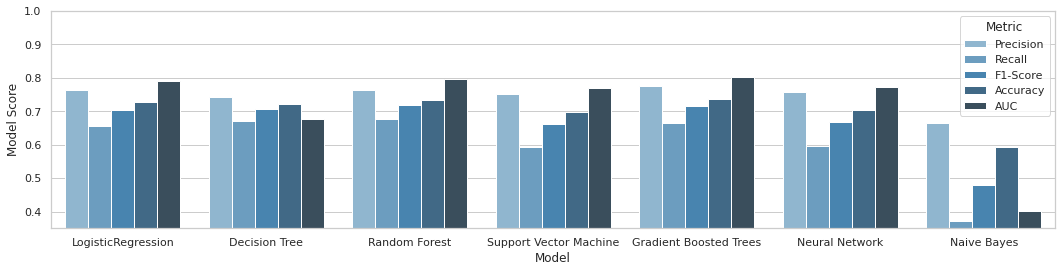

In [4]:
import matplotlib as mpl
rsModel = ['LogisticRegression','Decision Tree','Random Forest','Support Vector Machine','Gradient Boosted Trees','Neural Network','Naive Bayes']
rs = pd.DataFrame(index = range(7*5))
rs['Model'] = np.array(rsModel*5)
Precision = [0.764,0.743,0.763, 0.75, 0.774,0.758,0.666]
Recall = [0.655,0.672,0.678, 0.592, 0.666,0.597,0.373]
F1_Score = [0.705,0.706,0.718,0.662,0.716,0.668,0.478]
Accuracy = [0.727,0.721,0.734,0.698,0.737,0.704,0.594]
AUC = [0.791,0.676,0.796,0.768,0.803,0.771,0.403]
rs['Metric'] = np.array(['Precision']*7 + ['Recall']*7 + ['F1-Score']*7  + ['Accuracy']*7 + ['AUC']*7)
rs['Model Score'] = np.array(Precision + Recall + F1_Score  + Accuracy + AUC)
ax = sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 4))
ax = sns.barplot(data = rs, x="Model", y="Model Score", hue="Metric",palette = "Blues_d")
ax = ax.set(ylim=(0.35, 1))
mpl.rc_file_defaults()

The Logistic Regression, Random Forest and Gradient Boosted Trees perform nearly the same. <br>Naive Bayes had the worst performance. This might be related to the fact that some of the features such as high and low blood pressure are not independent. <br>
The recall of the models is not high. This implies that we will have many false negative predictions. For our case a false negative means predicting no cardiavascular condition when the patient actually does have a cardiovascular condition.
Overall the Gradient boosted tree performed better than other models. Now we look at how Gradient boosted tree perform with<br> **Feature Engineering**.<br>

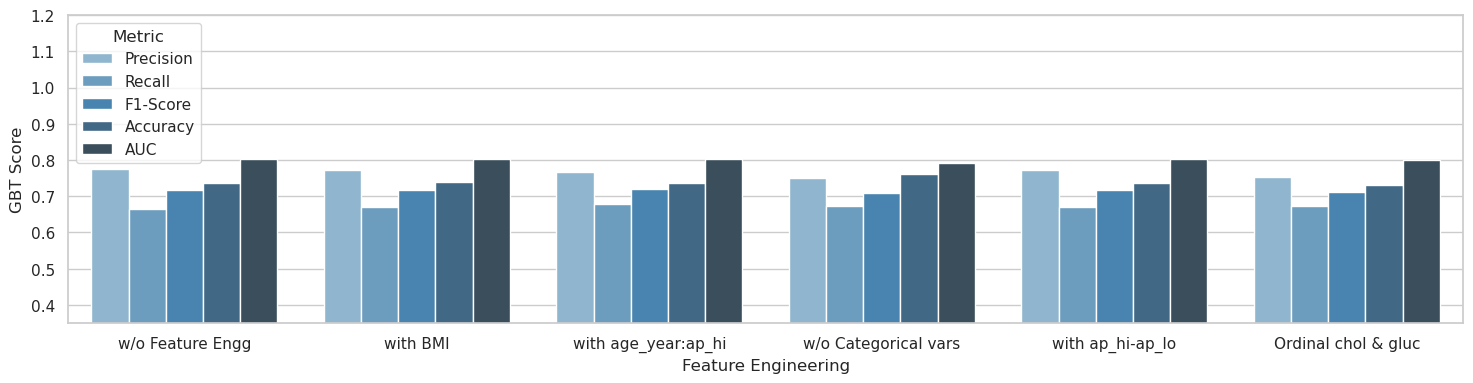

In [7]:
rsFeature = ['w/o Feature Engg','with BMI','with age_year:ap_hi','w/o Categorical vars','with ap_hi-ap_lo','Ordinal chol & gluc']
rs = pd.DataFrame(index = range(6*5))
rs['Feature Engineering'] = np.array(rsFeature*5)
Precision = [0.774,0.772,0.767,0.749,0.773,0.754]
Recall = [0.666,0.671,0.679,0.673,0.67,0.674]
F1_Score = [0.716,0.718,0.72,0.709,0.718,0.712]
Accuracy = [0.737,0.738,0.737,0.762,0.737,0.731]
AUC = [0.803,0.803,0.804,0.793,0.803,0.8]
rs['Metric'] = np.array(['Precision']*6 + ['Recall']*6 + ['F1-Score']*6  + ['Accuracy']*6 + ['AUC']*6)
rs['GBT Score'] = np.array(Precision + Recall + F1_Score  + Accuracy + AUC)
ax = sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 4))
ax = sns.barplot(data = rs, x="Feature Engineering", y="GBT Score", hue="Metric",palette = "Blues_d")
ax = ax.set(ylim=(0.35, 1.2))
mpl.rc_file_defaults()

We do not see any significant improvement in Gradient Boosted Tree model performance with the addition of engineered features.<br>
***Overall results***<br>
For our dataset we find that systolic blood pressure, diastolic blood pressure, age and cholesterol play an important role in predicting cardiovascular disease. 

***Future work***<br>
1. Try deep neural networks.<br>
2. Try SVM with higher order kernels.<br>
3. Collect more data. Increasing the size of the dataset may improve model performance.
4. Our data may not have enough features. Collect additional feature data to enrich the data set.

<a id='Appendix'></a>
## 6. Appendix

<a id='Chi_Square_test'></a>
### 6.1. Chi-Square test

In section 2 we see that activity, smoking and alcohol consumption doesn't seem to contribure to cardiovascular condition for our dataset. Here we verify this claim through statistical test. Since all of these features are categorical variables we performed **Chi-Squared test**<br><br>
We group the categorical variables count alco,smoke,active categories based on our target variable cardio

#### 6.1.1. Chi-Squared test - alco

In [25]:
expr1 = col('alco') == 1
df.where(expr1).groupBy('cardio').agg(count('alco').alias('alco')).show()
expr1 = col('alco') == 0
df.where(expr1).groupBy('cardio').agg(count('alco').alias('alco')).show()

+------+----+
|cardio|alco|
+------+----+
|     1|1759|
|     0|1923|
+------+----+

+------+-----+
|cardio| alco|
+------+-----+
|     1|32256|
|     0|32793|
+------+-----+



In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
data = [(1.0, Vectors.dense(1.0)) for x in range(1759)] + [(1.0, Vectors.dense(0.0)) for x in range(1923)]\
        + [(0.0, Vectors.dense(1.0)) for x in range(32256)] + [(0.0, Vectors.dense(0.0)) for x in range(32793)]
df = spark.createDataFrame(data, ["label", "features"])
r = ChiSquareTest.test(df, "features", "label")
r.show(truncate=False)

+---------------------+----------------+-------------------+
|pValues              |degreesOfFreedom|statistics         |
+---------------------+----------------+-------------------+
|[0.03218378188221782]|[1]             |[4.588680491622504]|
+---------------------+----------------+-------------------+



#### 6.1.2. Chi-Squared test - smoke

In [26]:
expr1 = col('smoke') == 1
df.where(expr1).groupBy('cardio').agg(count('smoke').alias('smoke')).show()
expr1 = col('smoke') == 0
df.where(expr1).groupBy('cardio').agg(count('smoke').alias('smoke')).show()

+------+-----+
|cardio|smoke|
+------+-----+
|     1| 2836|
|     0| 3213|
+------+-----+

+------+-----+
|cardio|smoke|
+------+-----+
|     1|31179|
|     0|31503|
+------+-----+



In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
data = [(1.0, Vectors.dense(1.0)) for x in range(2836)] + [(1.0, Vectors.dense(0.0)) for x in range(3213)]\
        + [(0.0, Vectors.dense(1.0)) for x in range(31179)] + [(0.0, Vectors.dense(0.0)) for x in range(31503)]
df = spark.createDataFrame(data, ["label", "features"])
r = ChiSquareTest.test(df, "features", "label")
r.show(truncate=False)

+----------------------+----------------+--------------------+
|pValues               |degreesOfFreedom|statistics          |
+----------------------+----------------+--------------------+
|[2.182214136581262E-5]|[1]             |[18.023267570665233]|
+----------------------+----------------+--------------------+



#### 6.1.3. Chi-Squared test - active

In [27]:
expr1 = col('active') == 1
df.where(expr1).groupBy('cardio').agg(count('active').alias('active')).show()
expr1 = col('active') == 0
df.where(expr1).groupBy('cardio').agg(count('active').alias('active')).show()

+------+------+
|cardio|active|
+------+------+
|     1| 26819|
|     0| 28403|
+------+------+

+------+------+
|cardio|active|
+------+------+
|     1|  7196|
|     0|  6313|
+------+------+



In [3]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
data = [(1.0, Vectors.dense(1.0)) for x in range(26819)] + [(1.0, Vectors.dense(0.0)) for x in range(28403)]\
        + [(0.0, Vectors.dense(1.0)) for x in range(7196)] + [(0.0, Vectors.dense(0.0)) for x in range(6313)]
df = spark.createDataFrame(data, ["label", "features"])
r = ChiSquareTest.test(df, "features", "label")
r.show(truncate=False)

+-------+----------------+-------------------+
|pValues|degreesOfFreedom|statistics         |
+-------+----------------+-------------------+
|[0.0]  |[1]             |[96.01242852818343]|
+-------+----------------+-------------------+



Question Is there Evidence at the 0.05 significance level of a difference in cardio  among  inactive, smoker and drinkers<br>
Null hypothesis population proportion for cardio among inactive, smokers and drinkers is the same (active=0, smoke=1 = alco=1)

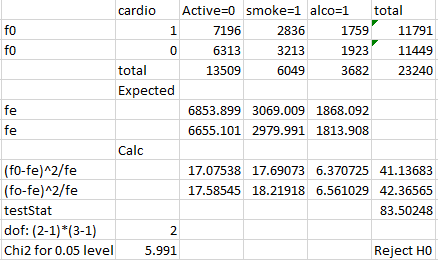

Question Is there Evidence at the 0.05 significance level of a difference in cardio  among  active, non-smoker and non-drinkers<br>
Null hypothesis population proportion for cardio among active, non-smokers and non-drinkers is the same (active=1, smoke=0 =, alco=0)<br>

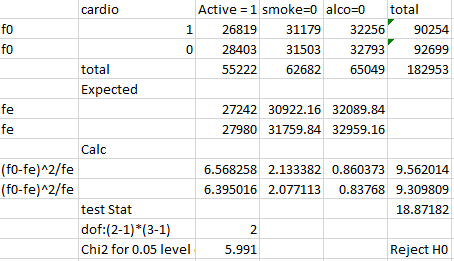

Conclusion from Chi-squared test:<br>
For our data set there is evidence that there is difference in cardiovascular condition among smokers, drinkers and inactive people.<br>
For our data set there is evidence that there is difference in cardiovascular condition among non-smokers, non-drinkers and active people.

<a id='ROC_Curve'></a>
### 6.2. ROC Curve

In [49]:
supervised = RFormula(formula='cardio ~ .')
fittedRF = supervised.fit(df_enc)
preparedDF = fittedRF.transform(df_enc)
lr_inst = LogisticRegression().setLabelCol("label").setFeaturesCol("features")
lrModel = lr_inst.fit(preparedDF)
summary = lrModel.summary

Text(0, 0.5, 'TPR')

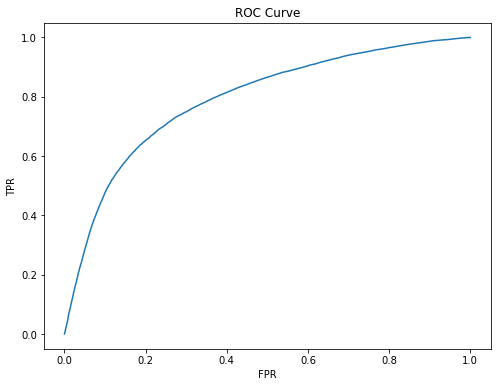

In [50]:
roc = summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

<a id='PCA'></a>
### 6.3. PCA

In [17]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors
import seaborn as sns

In [ ]:
supervised = RFormula(formula='cardio ~ .')
fittedRF = supervised.fit(df_enc)
preparedDF = fittedRF.transform(df_enc)
pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(preparedDF)
transformed = model.transform(preparedDF)

In [56]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
pcaDF = transformed.select(firstElement('pca'), secondElement('pca'), 'cardio').toPandas()
pcaDF.columns = ['pc1', 'pc2', 'cardio']

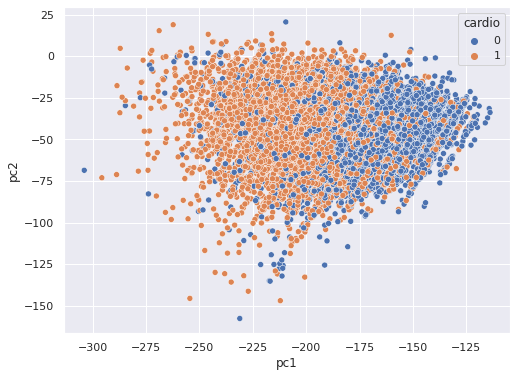

In [57]:
sns.set(rc={'figure.figsize':(8,6)})  # Figure size
sns.scatterplot(data=pcaDF, x='pc1', y='pc2',palette = "Paired", hue='cardio');

In [58]:
model.explainedVariance

DenseVector([0.5336, 0.2613])

conclusions from PCA:<br>
The first 2 principal components explain 79.5% of the model variance.<br>
The plot shows that the cardio and the non-cardio instances have considerable overlap and are not separated. This might explain to some some degree why the classifiers have average performance.